In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from pathlib import Path
import tmdbsimple as tmdb
import json
import sys

sys.path.append('../src')

from cleaning import create_actors_dataframe

project_path = Path().cwd().parent.parent
data_path = project_path / "data"

In [2]:
tmdb.API_KEY = 'f242e2c5e2deab7ec67acb9a3722f983'

movies = pd.read_csv(data_path / "tmdb-movie-metadata" / "tmdb_5000_movies.csv")
credits = pd.read_csv(data_path / "tmdb-movie-metadata" / "tmdb_5000_credits.csv")

In [3]:
movies.head(2)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500


In [53]:
movies.loc[0, "release_date"][:4]

'2009'

In [32]:
import json 

In [44]:
def get_genres(df):
    all_genre = []
    for k in range(0, df.shape[0]):
        for genre in json.loads(movies.loc[k, "genres"]):
            if genre["name"] not in all_genre:
                all_genre.append(genre["name"])
                
    return all_genre

In [45]:
get_genres(movies)

['Action',
 'Adventure',
 'Fantasy',
 'Science Fiction',
 'Crime',
 'Drama',
 'Thriller',
 'Animation',
 'Family',
 'Western',
 'Comedy',
 'Romance',
 'Horror',
 'Mystery',
 'History',
 'War',
 'Music',
 'Documentary',
 'Foreign',
 'TV Movie']

In [46]:
def get_production_companies(df):
    all_companies = []
    for k in range(0, df.shape[0]):
        for companies in json.loads(movies.loc[k, "production_companies"]):
            if companies["name"] not in all_companies:
                all_companies.append(companies["name"])
                
    return all_companies

def get_production_countries(df):
    all_countries = []
    for k in range(0, df.shape[0]):
        for all_countries in json.loads(movies.loc[k, "production_companies"]):
            if companies["name"] not in all_countries:
                all_countries.append(companies["name"])
                
    return all_companies

In [50]:
get_production_companies(movies)

['Ingenious Film Partners',
 'Twentieth Century Fox Film Corporation',
 'Dune Entertainment',
 'Lightstorm Entertainment',
 'Walt Disney Pictures',
 'Jerry Bruckheimer Films',
 'Second Mate Productions',
 'Columbia Pictures',
 'Danjaq',
 'B24',
 'Legendary Pictures',
 'Warner Bros.',
 'DC Entertainment',
 'Syncopy',
 'Laura Ziskin Productions',
 'Marvel Enterprises',
 'Walt Disney Animation Studios',
 'Marvel Studios',
 'Prime Focus',
 'Revolution Sun Studios',
 'Heyday Films',
 'DC Comics',
 'Atlas Entertainment',
 'Cruel & Unusual Films',
 'RatPac-Dune Entertainment',
 'Bad Hat Harry Productions',
 'Eon Productions',
 'Infinitum Nihil',
 'Silver Bullet Productions (II)',
 'Blind Wink Productions',
 'Classic Media',
 'Cruel and Unusual Films',
 'Walt Disney',
 'Walden Media',
 'Stillking Films',
 'Ozumi Films',
 'Propeler',
 'Silverbell Films',
 'Paramount Pictures',
 'Moving Picture Company (MPC)',
 'Amblin Entertainment',
 'Media Magik Entertainment',
 'Imagenation Abu Dhabi FZ',
 '

In [9]:
print(movies["genres"][0], '\n')
print(movies["keywords"][0], '\n')
print(movies["production_companies"][0], '\n')
print(movies["production_countries"][0], '\n')
print(movies["spoken_languages"][0], '\n')

[{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 878, "name": "Science Fiction"}] 

[{"id": 1463, "name": "culture clash"}, {"id": 2964, "name": "future"}, {"id": 3386, "name": "space war"}, {"id": 3388, "name": "space colony"}, {"id": 3679, "name": "society"}, {"id": 3801, "name": "space travel"}, {"id": 9685, "name": "futuristic"}, {"id": 9840, "name": "romance"}, {"id": 9882, "name": "space"}, {"id": 9951, "name": "alien"}, {"id": 10148, "name": "tribe"}, {"id": 10158, "name": "alien planet"}, {"id": 10987, "name": "cgi"}, {"id": 11399, "name": "marine"}, {"id": 13065, "name": "soldier"}, {"id": 14643, "name": "battle"}, {"id": 14720, "name": "love affair"}, {"id": 165431, "name": "anti war"}, {"id": 193554, "name": "power relations"}, {"id": 206690, "name": "mind and soul"}, {"id": 209714, "name": "3d"}] 

[{"name": "Ingenious Film Partners", "id": 289}, {"name": "Twentieth Century Fox Film Corporation", "id": 306}, {"name": "Dun

In [4]:
# cleaning of movies dataset
df = movies.copy()
df.keywords = df.keywords.map(lambda keywords: ' '.join([keyword['name'] for keyword in json.loads(keywords)]))

In [5]:
flatten = lambda l: [item for sublist in l for item in sublist]

In [11]:
# Create production_countries dataset
production_countries = flatten([json.loads(item) for index, item in df.production_countries.iteritems()])
production_countries = pd.DataFrame(production_countries).drop_duplicates()\
                                                         .reset_index(drop=True)
production_countries.to_csv(data_path / 'production_countries.csv')

In [12]:
# Create countries_produce_movies dataset
produce = pd.DataFrame({'production_country_id':[], 'movie_id':[]})
for index, row in movies.iterrows():
    countries = json.loads(row['production_countries'])
    for country in countries:
        code = country['iso_3166_1']
        production_country_id = production_countries[production_countries.iso_3166_1 == code].index.item()
        produce = produce.append({'production_country_id': int(production_country_id), 'movie_id': int(row['id'])}, ignore_index=True)

produce.production_country_id = produce.production_country_id.astype(np.int64)
produce.movie_id = produce.movie_id.astype(np.int64)
produce.to_csv(data_path / 'countries_produce_movies.csv', index=False)

In [13]:
# Create production_companies dataset
production_companies = flatten([json.loads(item) for index, item in movies.production_companies.iteritems()])
production_companies = pd.DataFrame(production_companies).drop_duplicates()\
                                                         .set_index('id')\
                                                         .sort_index()

production_companies.to_csv(data_path / 'production_companies.csv')

In [14]:
# Create companies_produce_movies dataset
produce = pd.DataFrame({'production_company_id':[], 'movie_id':[]})
for index, row in movies.iterrows():
    companies = json.loads(row['production_companies'])
    for companie in companies:
        produce = produce.append({'production_company_id': companie['id'], 'movie_id': row['id']}, ignore_index=True)

produce.production_company_id = produce.production_company_id.astype(np.int64)
produce.movie_id = produce.movie_id.astype(np.int64)
produce.to_csv(data_path / 'companies_produce_movies.csv', index=False)

In [15]:
credits.head()

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [23]:
actors = pd.read_csv(data_path / 'actors.csv')

In [24]:
actors.shape

(50815, 13)

## Exploration

In [25]:
movies.nunique()

budget                   436
genres                  1175
homepage                1691
id                      4803
keywords                4222
original_language         37
original_title          4801
overview                4800
popularity              4802
production_companies    3697
production_countries     469
release_date            3280
revenue                 3297
runtime                  156
spoken_languages         544
status                     3
tagline                 3944
title                   4800
vote_average              71
vote_count              1609
dtype: int64

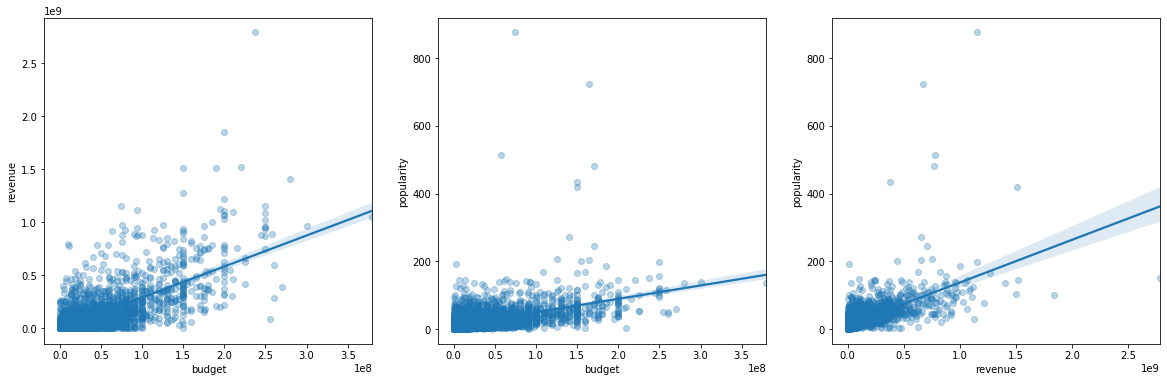

In [35]:
_, ax = plt.subplots(1, 3, figsize=(20, 6))

sns.regplot(data=movies, x='budget', y='revenue', scatter_kws=dict(alpha=0.3), ax=ax[0])
sns.regplot(data=movies, x='budget', y='popularity', scatter_kws=dict(alpha=0.3), ax=ax[1])
sns.regplot(data=movies, x='revenue', y='popularity', scatter_kws=dict(alpha=0.3), ax=ax[2])

plt.show()

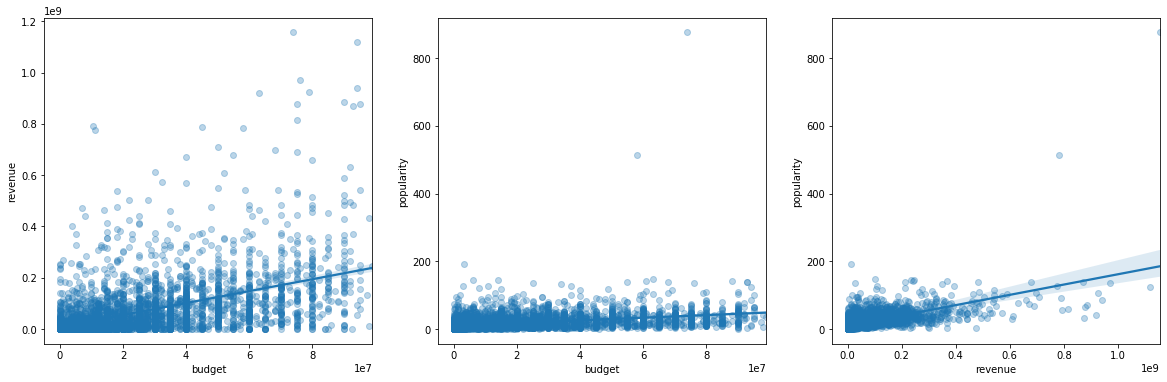

In [36]:
data = movies[movies.budget < 1e8]

_, ax = plt.subplots(1, 3, figsize=(20, 6))

sns.regplot(data=data, x='budget', y='revenue', scatter_kws=dict(alpha=0.3), ax=ax[0])
sns.regplot(data=data, x='budget', y='popularity', scatter_kws=dict(alpha=0.3), ax=ax[1])
sns.regplot(data=data, x='revenue', y='popularity', scatter_kws=dict(alpha=0.3), ax=ax[2])

plt.show()